In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
from types import SimpleNamespace
import os
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import xarray
import pandas as pd
from dataset.dataset import ImageDataset, SingleImageDataset
from dataset.normalization import MinMax, ZeroMinMax
from dataset.station_dataset import GroundstationDataset, GroundstationDataset2
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger
from models.ConvResNet_Jiang import ConvResNet, ConvResNet_dropout, ConvResNet_batchnormMLP
from models.LightningModule import LitEstimator, LitEstimatorPoint
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from utils.plotting import prediction_error_plot, plot_station_scatter
from cartopy.mpl.gridliner import (
    LongitudeFormatter,
    LatitudeFormatter,
    LongitudeLocator,
    LatitudeLocator,
)
plt.rcParams['text.usetex'] = False


In [3]:
def predictions_to_image(predictions, input_image, config, patch_size):

    y_hat = torch.cat([x[0] for x in predictions]).squeeze()
    y = torch.cat([x[1] for x in predictions]).squeeze()
    lat = torch.cat([x[2][:, 1] for x in predictions])
    lon = torch.cat([x[2][:, 2] for x in predictions])

    img_dim = (len(input_image.lon) - config.patch_size['x'] +1,
               len(input_image.lat) - config.patch_size['y'] +1,)
    
    y_hat = y_hat.reshape(img_dim)
    y = y.reshape(img_dim)
    lat = lat.reshape(img_dim)
    lon = lon.reshape(img_dim)

    y_hat = config.target_transform.inverse(y_hat, ["SIS"])
    y = config.target_transform.inverse(y, ["SIS"])
    lat = config.transform.inverse(lat, ["lat"])
    lon = config.transform.inverse(lon, ["lon"])

    output_image = xarray.DataArray(
        data=y_hat.T,
        # dims=('x','y'),
        coords={"lat": (('lat'), lat[0, :]),
                "lon": (('lon'), lon[:, 0]),},
        attrs=input_image.SIS.attrs,
    )

    output_image.lat.attrs = input_image.lat.attrs
    output_image.lon.attrs = input_image.lon.attrs
    return output_image, y, y_hat


def image_1d_to_2d(arr, dim, patch_size):
    return arr.reshape(
        dim[0] - patch_size["y"] + 1,
        dim[1] - patch_size["x"] + 1,
    )

def plot_comparison_image(output_image, ground_truth_image, extent=None, savefig = True):
    nm = ground_truth_image.name
    time = ground_truth_image.time.dt.strftime('%Y%m%d_%H%M').item()
    time_pretty = ground_truth_image.time.dt.strftime('%Y-%m-%d %H:%M').item()
    proj = ccrs.PlateCarree()
    # fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,6), subplot_kw={"projection": proj})
    fig = plt.figure(figsize=(12, 5))
    gs = fig.add_gridspec(
        2,
        4,
        width_ratios=(3, 3, 3, .2),
        height_ratios=(3,.125),
        left=0.1,
        right=0.9,
        bottom=0.1,
        top=0.9,
        wspace=0.05,
        hspace=0.1,
    )
    ax1 = fig.add_subplot(gs[0, 0], projection=proj)
    ax2 = fig.add_subplot(gs[0, 1], projection=proj, sharex=ax1, sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2], projection=proj, sharex=ax1, sharey=ax1)
    axc1 = fig.add_subplot(gs[1, :2], autoscale_on=False)
    axc2 = fig.add_subplot(gs[:, 3])
    
    ax_text = fig.add_subplot(gs[1,2])
    ax_text.axis('off')
    ax_text.annotate(time_pretty, 
                xycoords='axes fraction',
                xy=[.3, .5])

    output_image.plot.imshow(x='lon', y='lat', 
                             vmin=0, vmax=1100, 
                             ax=ax1, transform=proj, add_colorbar=False)
    ground_truth_image.plot.imshow(x='lon', y='lat', 
                                   vmin=0, vmax=1100, ax=ax2, 
                                   transform=proj, cbar_ax=axc1,
                                  cbar_kwargs={'orientation':'horizontal', 'shrink':0.6, 'aspect':40,'label':'SIS [W/m2]'})
    
    error = output_image - ground_truth_image.reindex_like(output_image, method="nearest")
    error.plot.imshow(ax=ax3, transform=proj, cbar_ax=axc2)
    ax1.set_title("DL")
    ax2.set_title("SARAH3")
    ax3.set_title("y_pred - y")
    
    gls = {}
    for i, ax in enumerate([ax1,ax2,ax3]):
        ax.coastlines()
        gl = ax.gridlines(draw_labels=True, linewidth=.3)
        gl.top_labels = False
        gl.right_labels = False
        if i>0:
            gl.left_labels = False
        

    
    if extent is not None:
        ax1.set_xlim([extent[0], extent[2]])
        ax1.set_ylim([extent[1], extent[3]])
    
    if savefig:
        
        if extent is not None:
            extent_str = '_'.join([str(x) for x in extent])
            fig.savefig(inference_fn  + f'{nm}_comparison_{time}_{extent_str}.png')
        else:
            pass
            fig.savefig(inference_fn + f'{nm}_comparison_{time}.png')

from torchmetrics import R2Score

r2score = R2Score()

def statistics_stations(predictions_stations, save = True, plot_text=True, stations_collection='BSRN'):
    
    metrics_fn = inference_fn + f'{stations_collection}_metrics.txt'
    with open(metrics_fn, 'w')as f:
        f.write('#station;bias;RMSE;MAE;R2\n')
        f.write('#-;w/m2;w/m2;w/m2;-\n')
    for key, val in predictions_stations.items():
        y_hat = config.transform.inverse(val['y_hat'].cpu(), ['SIS'])
        y = config.transform.inverse(val['y'].cpu(), ['SIS'])
        error = y_hat - y
        nan = ~error.isnan()
        # print(1-nan.sum().item()/error.shape[0], ' ratio of nans')
        error = error[nan]
        y=y[nan]
        y_hat=y_hat[nan]
        bias = torch.nanmean(error).item()
        mae = torch.nanmean(torch.abs(error)).item()
        std = torch.std(error).item()
        median = torch.nanmedian(error).item()
        rmse = torch.sqrt(torch.nanmean(error**2)).item()
        R2 = r2score(y_hat.clone().detach(), y.clone().detach()).item()
        val.update({'R2':R2, 'RMSE':rmse, 'MAE':mae, 'Bias':bias})    
        print(f"{key}: \t Bias: {round(bias)}\t RMSE: {round(rmse)} \t MAE: {round(mae)} \t R2score: {round(R2, 3)}")
        with open(metrics_fn, 'a') as f:
            f.write(f'{key};{round(bias,1)};{round(rmse,1)};{round(mae,1)};{round(R2, 3)}\n')
        fig = prediction_error_plot(y, y_hat, title=key)
        if save is True:
            fig.savefig(inference_fn + f'prediction_error_plot_{key}.png')
    
    latlon = torch.Tensor([(val['x'][0, 1], val['x'][0,2]) for val in predictions_stations.values()])
    latlon = config.transform.inverse(latlon, ["lat", "lon"])
    R2s = [val['R2'] for val in predictions_stations.values()]
    rmses = [val['RMSE'] for val in predictions_stations.values()]
    maes = [val['MAE'] for val in predictions_stations.values()]
    biass = [val['Bias'] for val in predictions_stations.values()]
    
    fig1 = plot_station_scatter(latlon[:,0], latlon[:,1], rmses, predictions_stations.keys(), 'RMSE', vmin=50, vmax=125, plot_text=plot_text)

    fig2 = plot_station_scatter(latlon[:,0], latlon[:,1], maes, predictions_stations.keys(), 'MAE', vmin=30, vmax=80, plot_text=plot_text)

    fig3 = plot_station_scatter(latlon[:,0], latlon[:,1], biass, predictions_stations.keys(), 'Bias', cmap='bwr', norm=colors.CenteredNorm(), plot_text=plot_text)
    if save:
        fig1.savefig(inference_fn + f'{stations_collection}_RMSE_plot.png')
        fig2.savefig(inference_fn + f'{stations_collection}_MAE_plot.png')
        fig3.savefig(inference_fn + f'{stations_collection}_bias_plot.png')
    
    


# Config

In [4]:


config = {
    "batch_size": 2048,
    "patch_size": {
        "x": 15,
        "y": 15,
        "stride_x": 1,
        "stride_y": 1,
    },
    "x_vars": [
        "channel_1",
        "channel_2",
        "channel_3",
        "channel_4",
        "channel_5",
        "channel_6",
        "channel_7",
        "channel_8",
        "channel_9",
        "channel_10",
        "channel_11",
        "DEM",
    ],
    "y_vars": ["SIS"],
    "x_features": ["dayofyear", "lat", "lon", "SZA", "AZI"],
    "transform": ZeroMinMax(),
    "target_transform": ZeroMinMax(),
}
config = SimpleNamespace(**config)



# Trainer and Model

In [5]:
# estimator = LitEstimator()
trainer = Trainer(
    # profiler="simple",
    # num_sanity_val_steps=2,
    accelerator="gpu",
    devices=1,
    precision="32",
)



# chkpt_fn = "../train/SIS_point_estimation/vh232f2j/checkpoints/epoch=11-step=11928.ckpt"
chkpt_fn = '../train/SIS_point_estimation/wv1ykh5d/checkpoints/epoch=8-step=8946.ckpt' # SARAH3 emulator
# chkpt_fn = '../train/SIS_point_estimation_groundstation/1otg6d0w/checkpoints/epoch=3-val_loss=0.01542.ckpt' # trained on 80 DWD groundstations
# chkpt_fn = '../train/SIS_point_estimation_groundstation/4krccmyz/checkpoints/epoch=0-val_loss=0.09168.ckpt' # retrained for bias on SARAH3
inference_fn = chkpt_fn.split('checkpoints')[0] + 'inference/'
if not os.path.exists(inference_fn):
    os.mkdir(inference_fn)

model = ConvResNet_batchnormMLP(
    num_attr=len(config.x_features),
    input_channels=len(config.x_vars),
    output_channels=len(config.y_vars),
)

# model = ConvResNet_dropout(
#     num_attr=len(config.x_features),
#     input_channels=len(config.x_vars),
#     output_channels=len(config.y_vars),
# )
estimator = LitEstimatorPoint.load_from_checkpoint(
    chkpt_fn,
    learning_rate=0.001,
    model=model,
    config=config,
)

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'metric' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric'])`.


# Station dataset

## BSRN

In [6]:
names = ['CAB','CAR','CEN','MIL','NOR','PAL','PAY','TAB','TOR','VIS']

test_datasets = [GroundstationDataset(fn, 
                                config.y_vars, config.x_vars, config.x_features, 
                                       config.patch_size['x'], 12, config.transform, config.target_transform, sarah_idx_only=True)
                for fn in names]


/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:201: invalid value encountered in cast
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:201: invalid value encountered in cast
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:201: invalid value encountered in cast
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:201: invalid value encountered in cast
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:201: invalid value encountered in cast
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:201: invalid value encountered in cast
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:201: invalid value encountered in cast
/scratch/snx3000/kschuurm/lightning-env/l

In [7]:
predictions_stations = [trainer.predict(estimator, DataLoader(ds, 2000, shuffle=False)) for ds in test_datasets]

predictions_stations = { nm: {'y_hat': torch.cat([p[0] for p in pred]),
                              'y': torch.cat([p[1] for p in pred]),
                              'x': torch.cat([p[2] for p in pred]) } for nm, pred in zip(names, predictions_stations)}

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

../train/SIS_point_estimation/wv1ykh5d/checkpoints/epoch=8-step=8946.ckpt
CAB: 	 Bias: 5	 RMSE: 89 	 MAE: 62 	 R2score: 0.853
CAR: 	 Bias: 5	 RMSE: 77 	 MAE: 53 	 R2score: 0.923
CEN: 	 Bias: 1	 RMSE: 91 	 MAE: 63 	 R2score: 0.89
MIL: 	 Bias: 12	 RMSE: 78 	 MAE: 54 	 R2score: 0.922
NOR: 	 Bias: -4	 RMSE: 80 	 MAE: 54 	 R2score: 0.876
PAL: 	 Bias: 3	 RMSE: 91 	 MAE: 62 	 R2score: 0.873
PAY: 	 Bias: 3	 RMSE: 88 	 MAE: 61 	 R2score: 0.896
TAB: 	 Bias: -11	 RMSE: 82 	 MAE: 57 	 R2score: 0.927
TOR: 	 Bias: 0	 RMSE: 89 	 MAE: 61 	 R2score: 0.843
VIS: 	 Bias: -9	 RMSE: 148 	 MAE: 52 	 R2score: 0.73


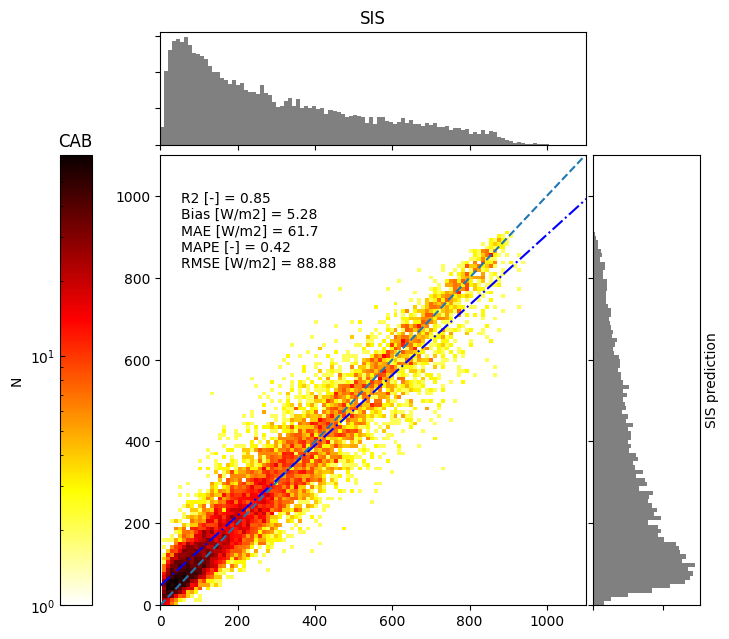

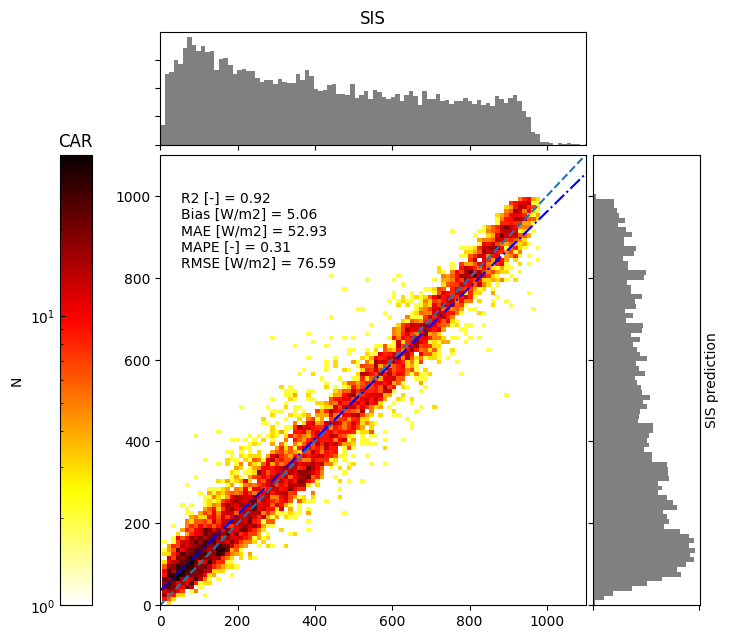

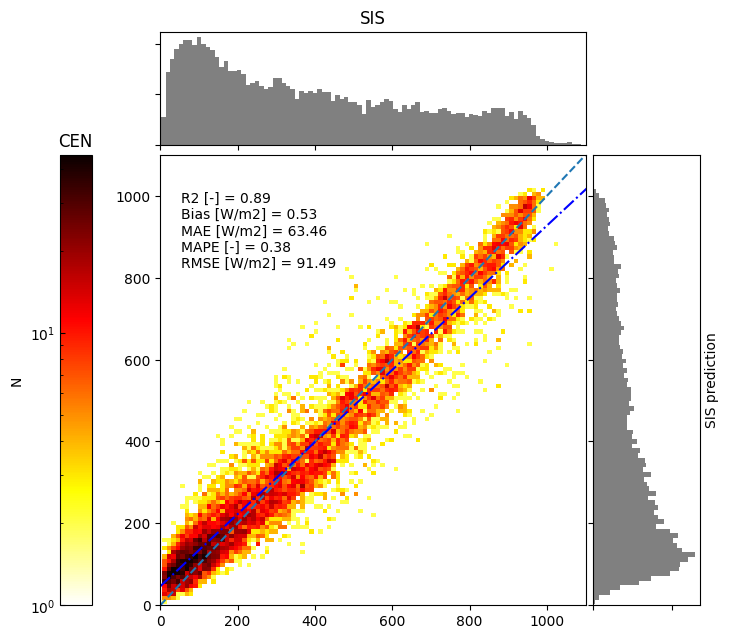

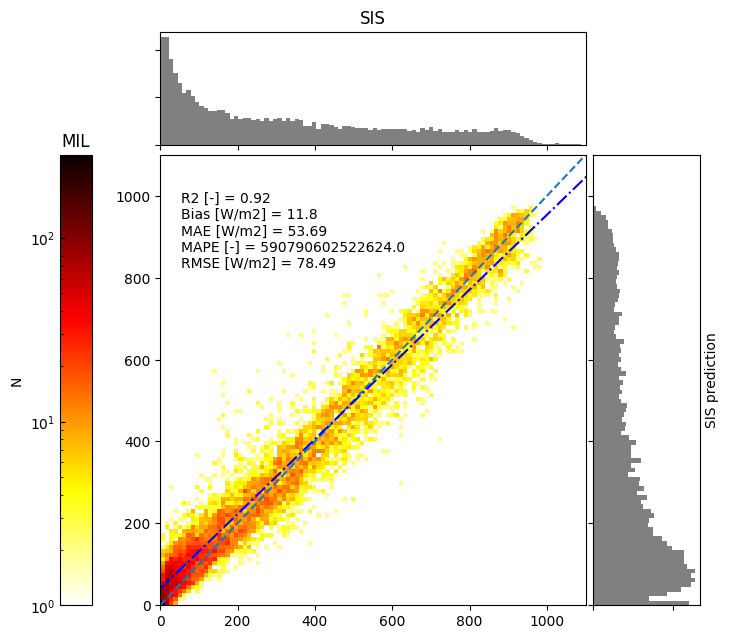

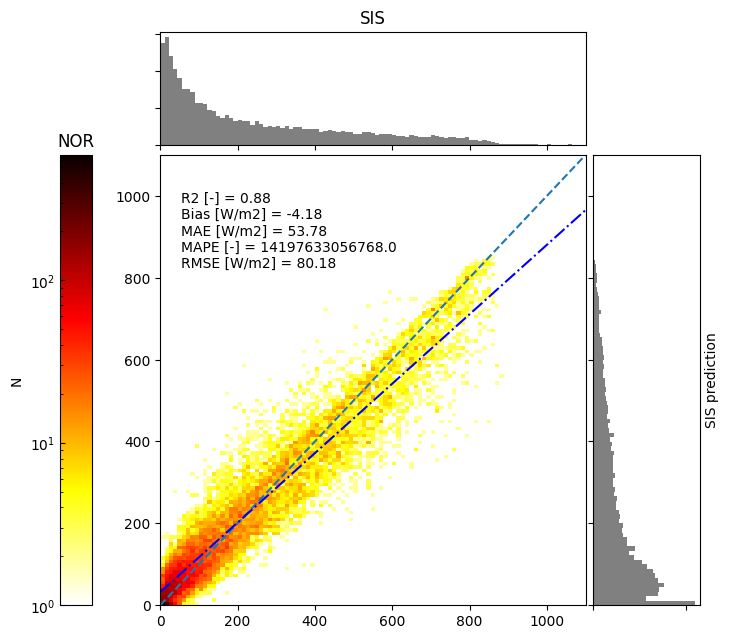

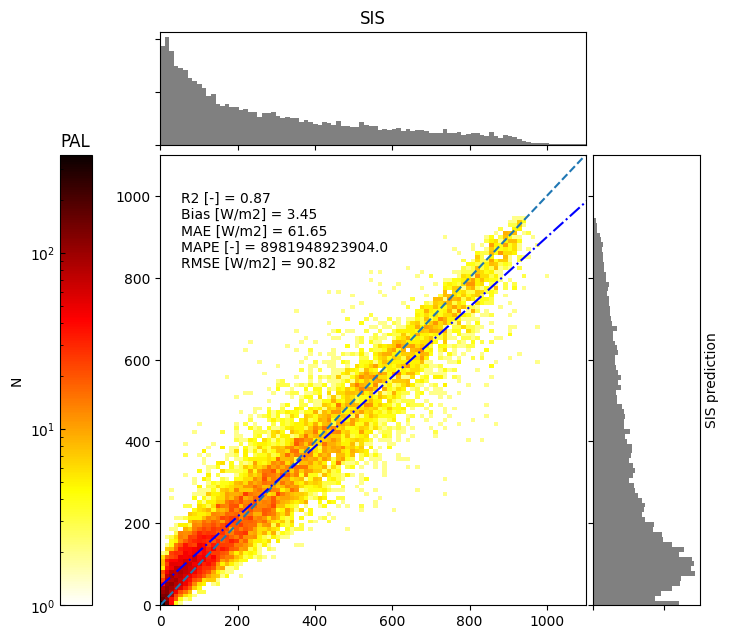

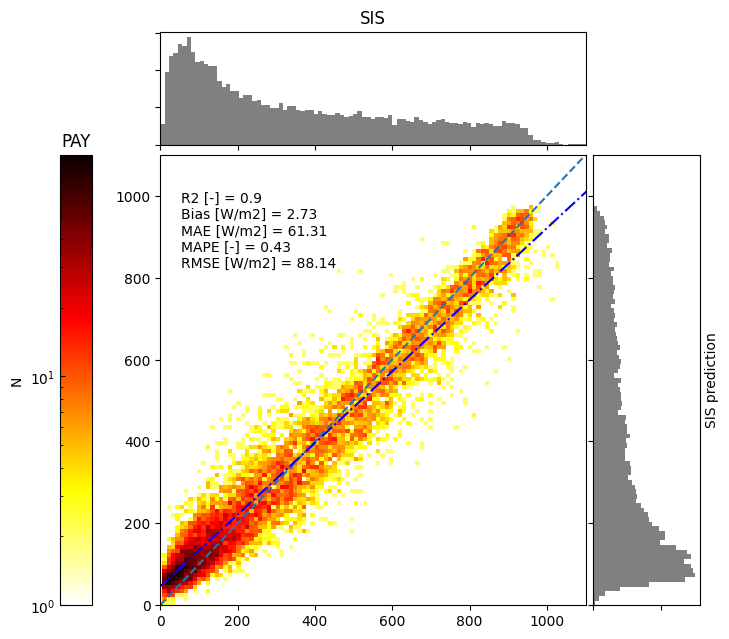

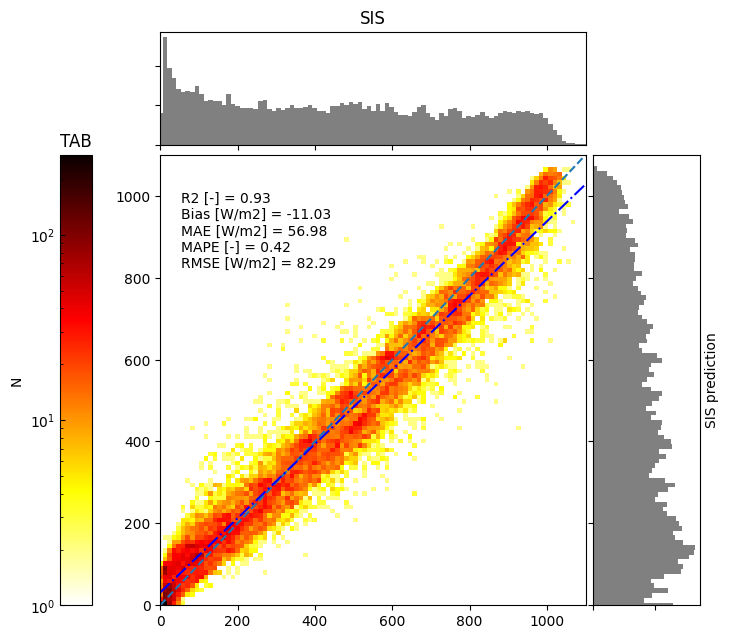

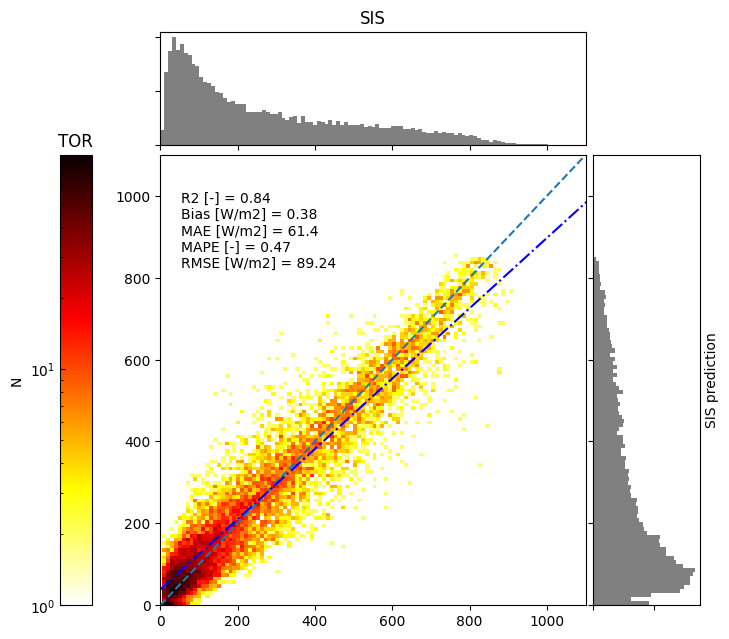

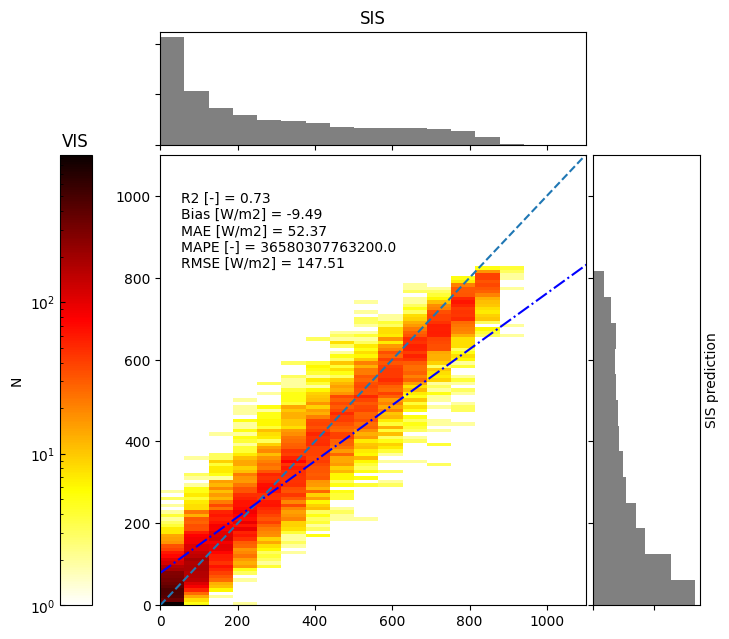

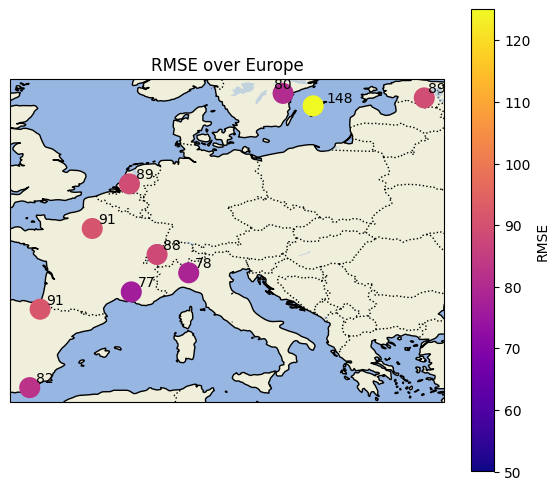

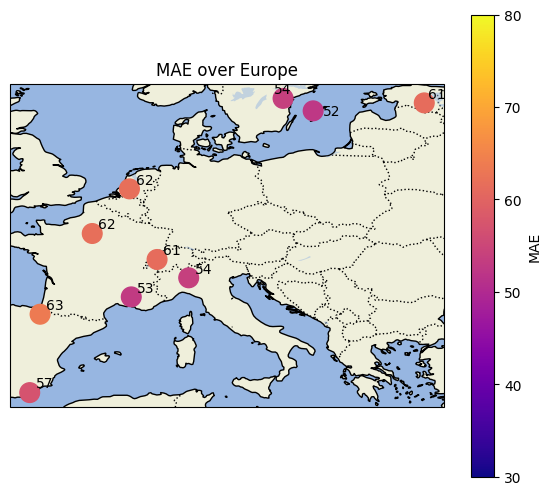

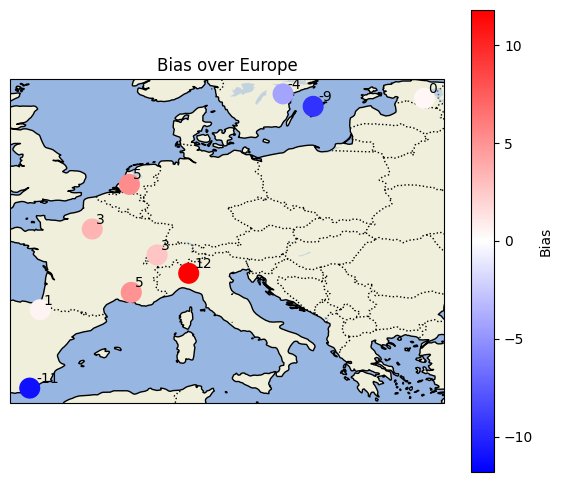

In [8]:
print(chkpt_fn)
statistics_stations(predictions_stations, True, True)

## DWD

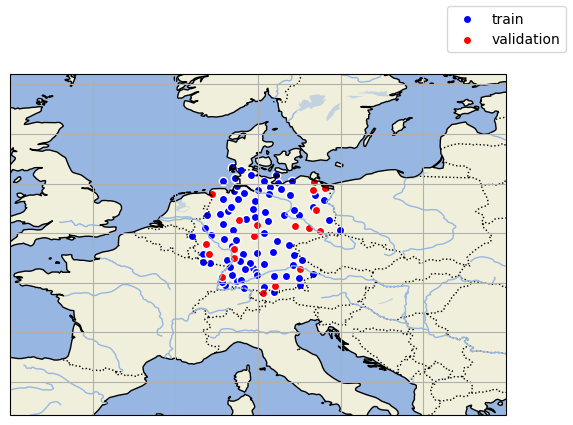

In [9]:
zarr_fns = glob('../../ZARR/DWD/DWD_SOLAR_*.zarr')
station_names = [int(os.path.basename(fn).split('SOLAR_')[-1].split('.')[0]) for fn in zarr_fns]
index = xarray.open_dataset('/scratch/snx3000/kschuurm/DATA/DWD/netcdf/DWD_SOLAR_index.nc')
index = index.sel(station_id=station_names)

# train_id, valid_id = torch.utils.data.random_split(station_names, [.8, .2])
# print(list(train_id), list(valid_id))

train_id = [15000, 2638, 662, 342, 691, 4104, 1684, 5426, 1766, 3167, 596, 880, 1346, 4271, 1550, 3196, 5792, 2485, 856, 1468, 3287, 4336, 701, 3126, 891, 1078, 4393, 963, 5705, 5546, 7368, 4887, 164, 704, 2261, 656, 2559, 6197, 3513, 3032, 7351, 430, 1443, 2907, 5856, 5404, 6163, 2483, 3268, 2601, 15444, 13674, 7374, 5480, 7367, 4745, 2014, 4625, 5100, 3761, 460, 7369, 3086, 3366, 282, 591, 1639, 232, 4177, 7370, 2667, 4928, 2712, 4466, 5397, 5516, 1975, 1503, 2115, 1605]
valid_id = [1757, 5109, 953, 3028, 2290, 5906, 2171, 427, 2932, 2812, 5839, 1691, 3811, 1420, 5142, 4911, 3660, 3730, 1048]

index_train = index.sel(station_id=train_id); index_valid = index.sel(station_id=valid_id)

a = index_train.plot.scatter(x='lon', y='lat', c='b', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
index_valid.plot.scatter(x='lon', y='lat', c='r', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
a.axes.gridlines()
a.axes.set_extent([-5, 25, 40, 60])
ax = a.axes
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
plt.gcf().legend(['train', 'validation'])
plt.show()


In [10]:
valid_datasets = [GroundstationDataset2(f'../../ZARR/DWD/DWD_SOLAR_{str(x).zfill(5)}.zarr', 
                                        config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], 
                                        config.transform, config.target_transform, sarah_idx_only=True)
                            for x in tqdm(valid_id)]


100%|██████████| 19/19 [03:20<00:00, 10.56s/it]


In [11]:
predictions_stations = [trainer.predict(estimator, DataLoader(ds, 2000, shuffle=False)) for ds in valid_datasets]

predictions_validation = { nm: {'y_hat': torch.cat([p[0] for p in pred]),
                              'y': torch.cat([p[1] for p in pred]),
                              'x': torch.cat([p[2] for p in pred]) } for nm, pred in zip(valid_id, predictions_stations)}

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

1757: 	 Bias: 11	 RMSE: 80 	 MAE: 53 	 R2score: 0.885
5109: 	 Bias: 16	 RMSE: 84 	 MAE: 55 	 R2score: 0.869
953: 	 Bias: 15	 RMSE: 91 	 MAE: 62 	 R2score: 0.864
3028: 	 Bias: 23	 RMSE: 84 	 MAE: 58 	 R2score: 0.87
2290: 	 Bias: 3	 RMSE: 93 	 MAE: 62 	 R2score: 0.878
5906: 	 Bias: 11	 RMSE: 87 	 MAE: 57 	 R2score: 0.886
2171: 	 Bias: 24	 RMSE: 86 	 MAE: 59 	 R2score: 0.873
427: 	 Bias: 2	 RMSE: 83 	 MAE: 56 	 R2score: 0.886
2932: 	 Bias: 5	 RMSE: 83 	 MAE: 55 	 R2score: 0.893
2812: 	 Bias: 20	 RMSE: 79 	 MAE: 54 	 R2score: 0.91
5839: 	 Bias: 12	 RMSE: 81 	 MAE: 54 	 R2score: 0.875
1691: 	 Bias: 17	 RMSE: 85 	 MAE: 58 	 R2score: 0.873
3811: 	 Bias: 18	 RMSE: 81 	 MAE: 55 	 R2score: 0.884
1420: 	 Bias: 16	 RMSE: 94 	 MAE: 61 	 R2score: 0.883
5142: 	 Bias: 11	 RMSE: 79 	 MAE: 53 	 R2score: 0.882
4911: 	 Bias: 14	 RMSE: 85 	 MAE: 58 	 R2score: 0.892
3660: 	 Bias: 27	 RMSE: 87 	 MAE: 60 	 R2score: 0.861
3730: 	 Bias: -4	 RMSE: 102 	 MAE: 69 	 R2score: 0.853
1048: 	 Bias: 9	 RMSE: 87 	 MAE: 5

/scratch/snx3000/kschuurm/irradiance_estimation/utils/plotting.py:323: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={'projection': proj})


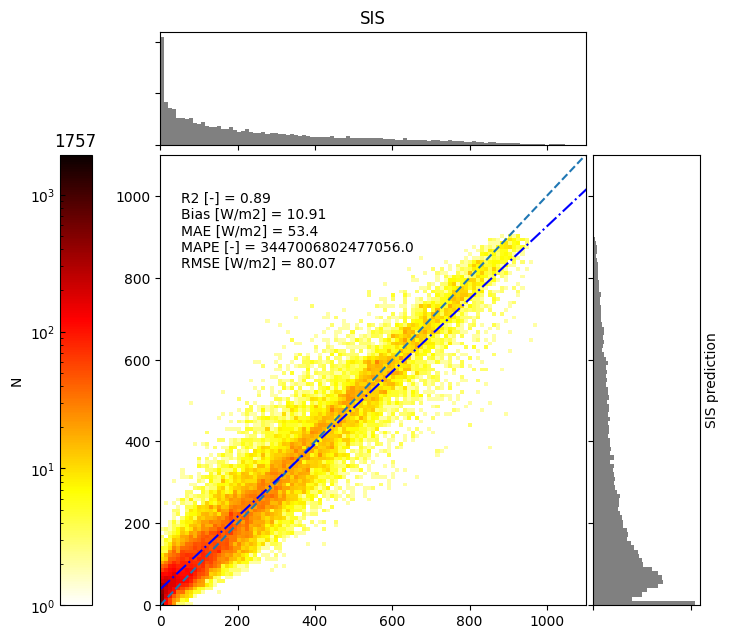

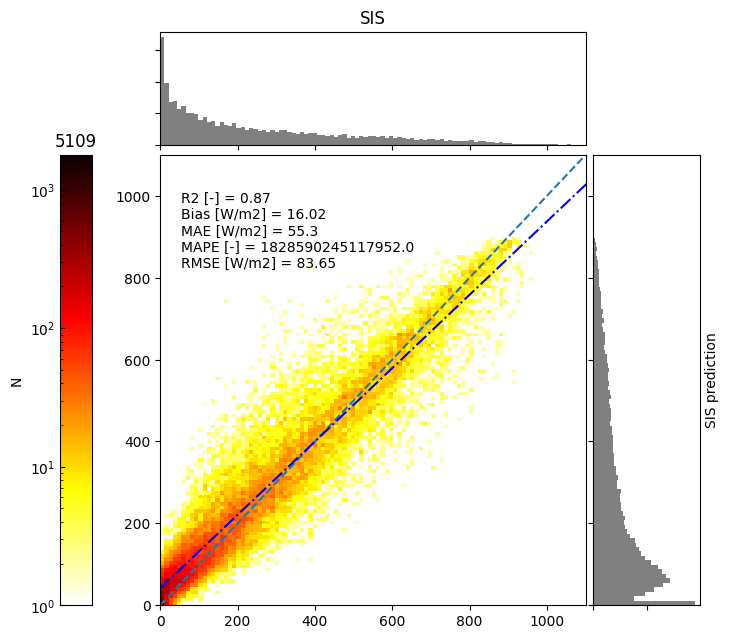

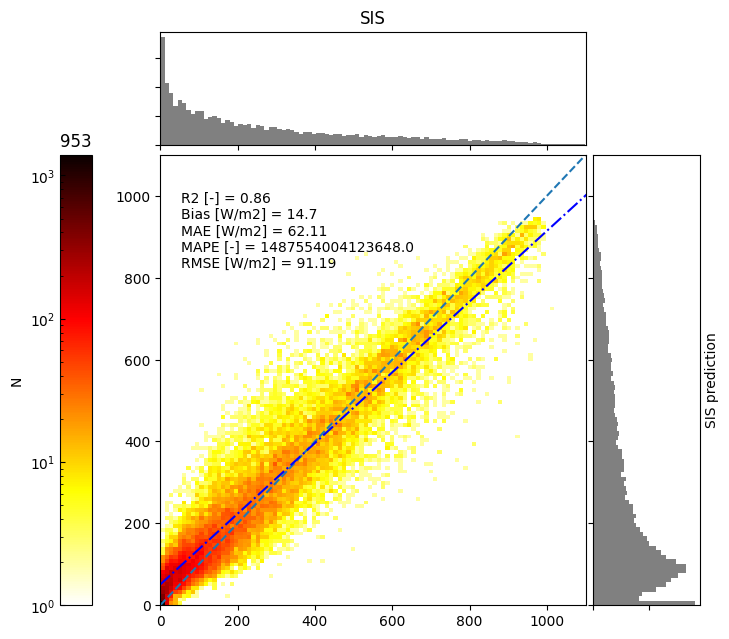

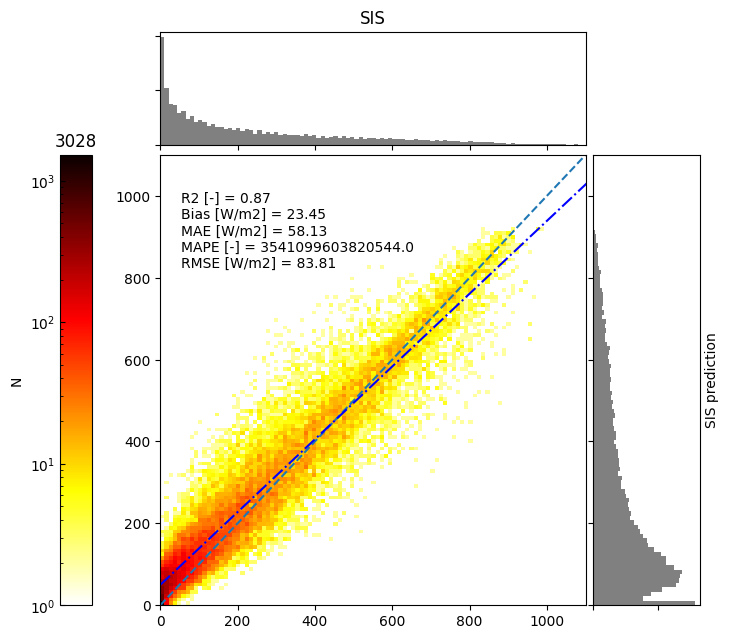

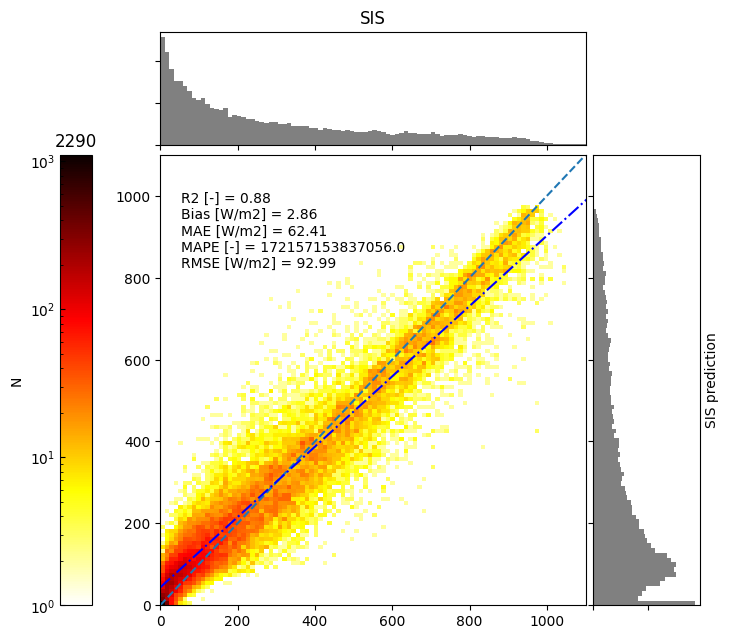

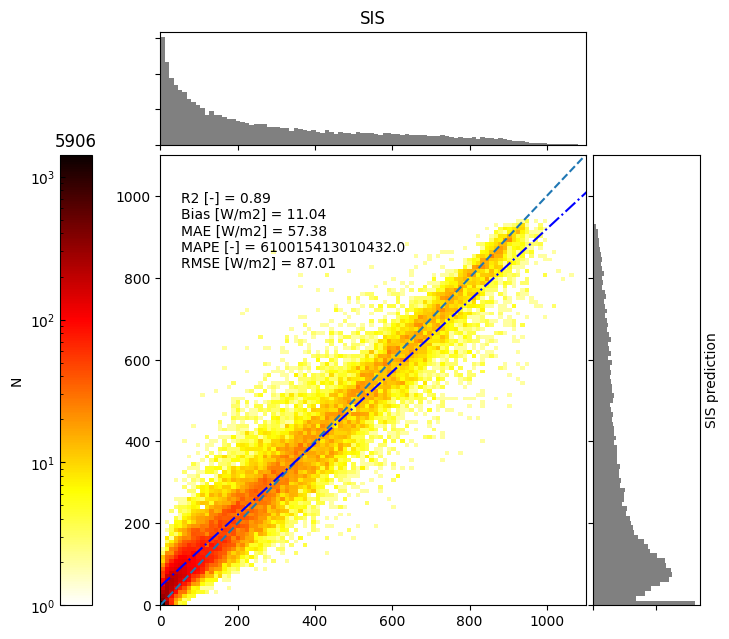

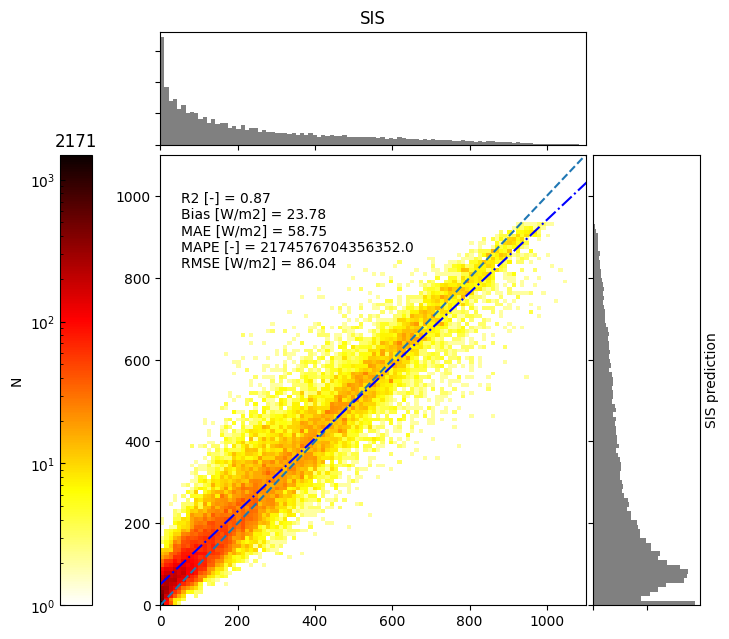

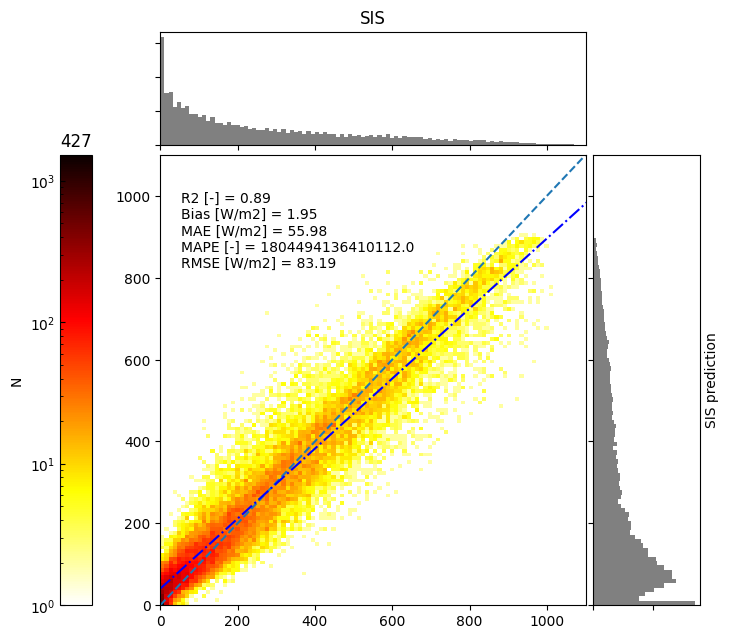

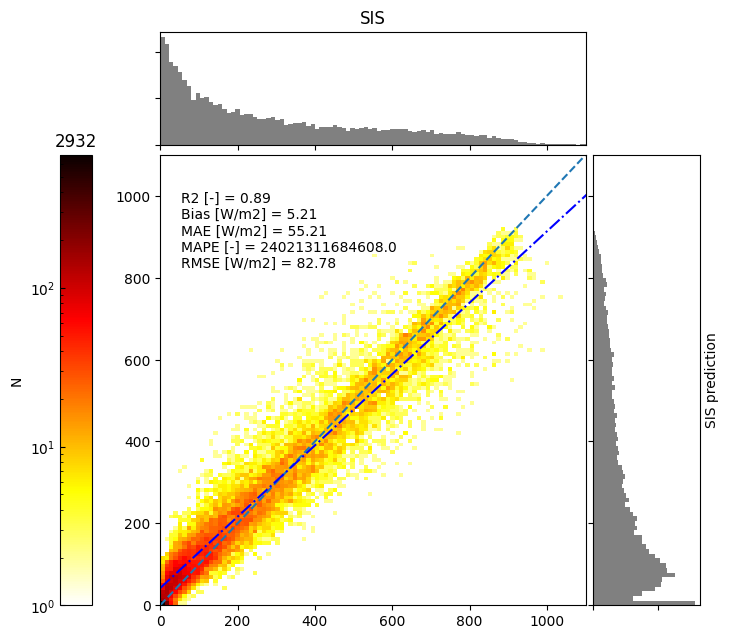

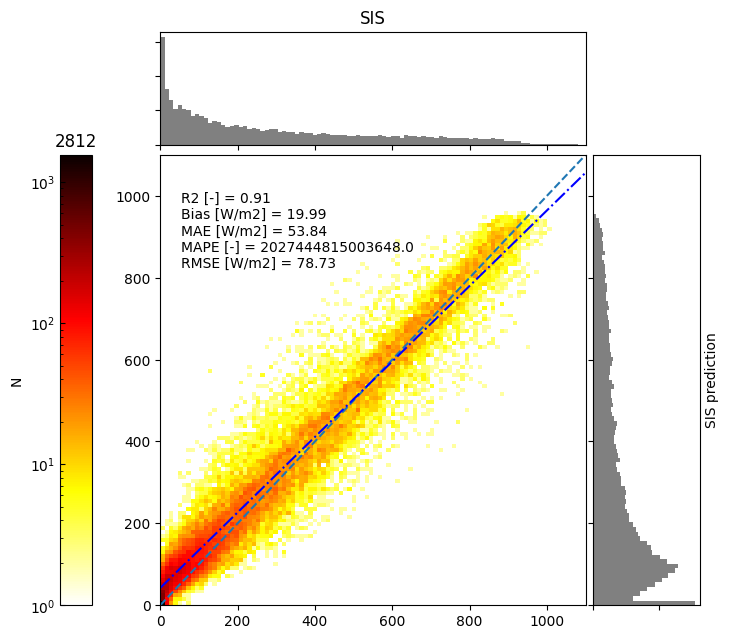

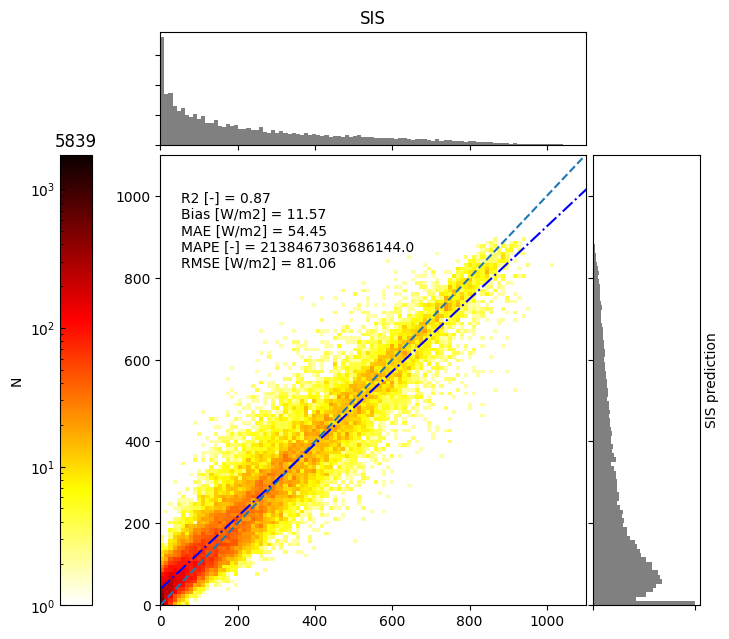

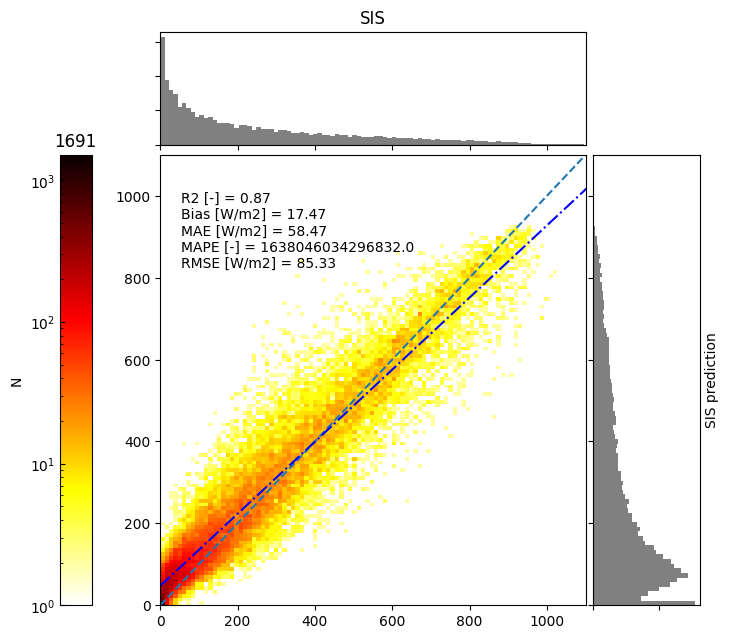

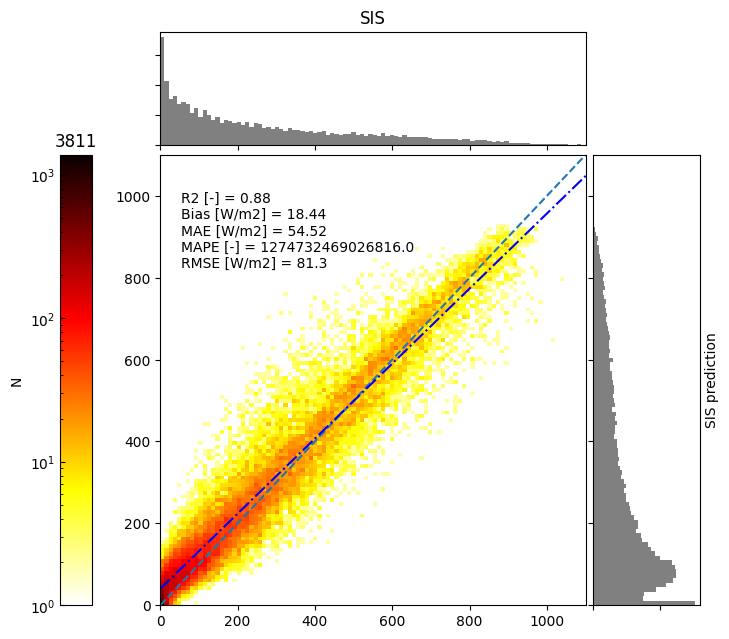

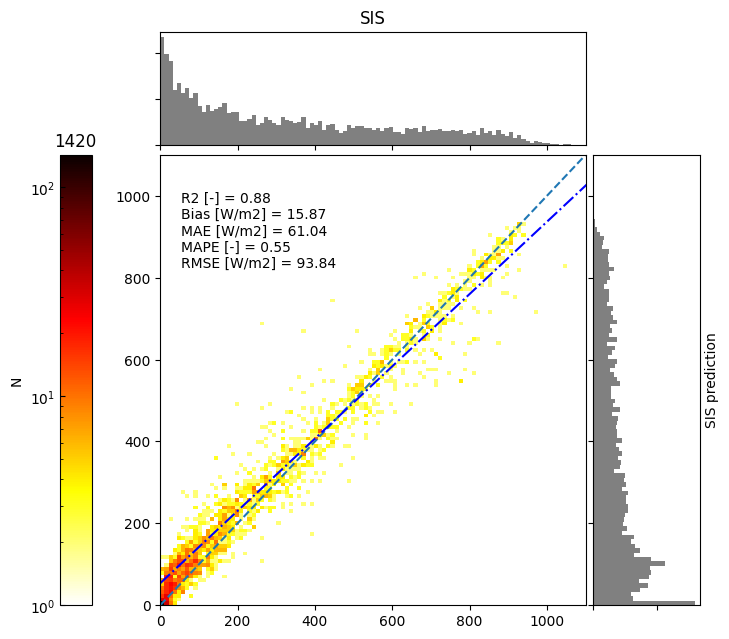

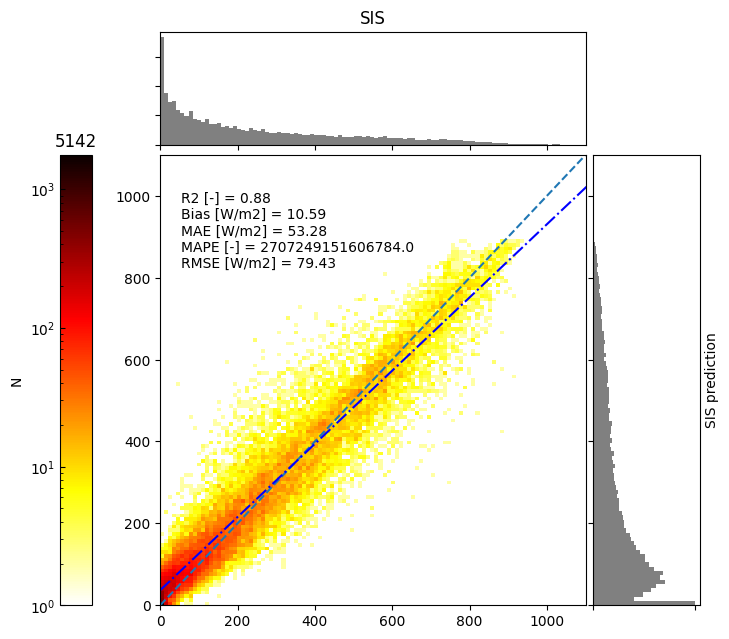

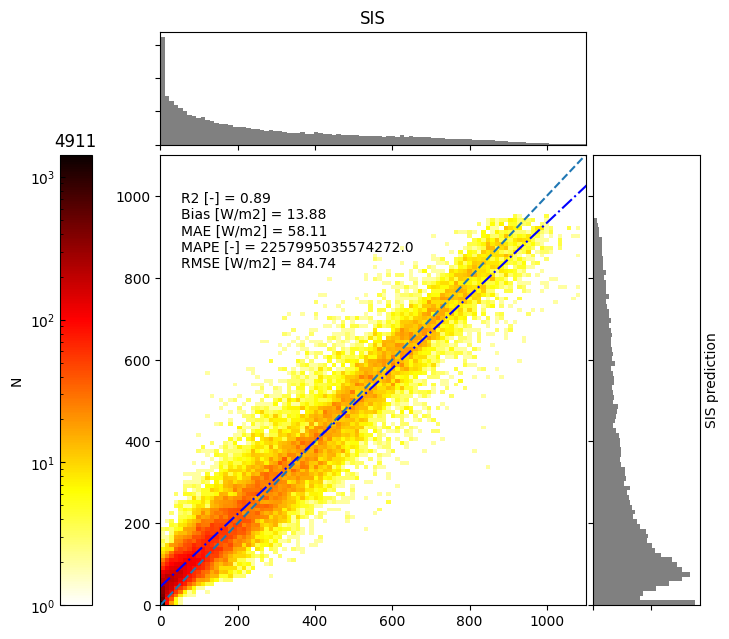

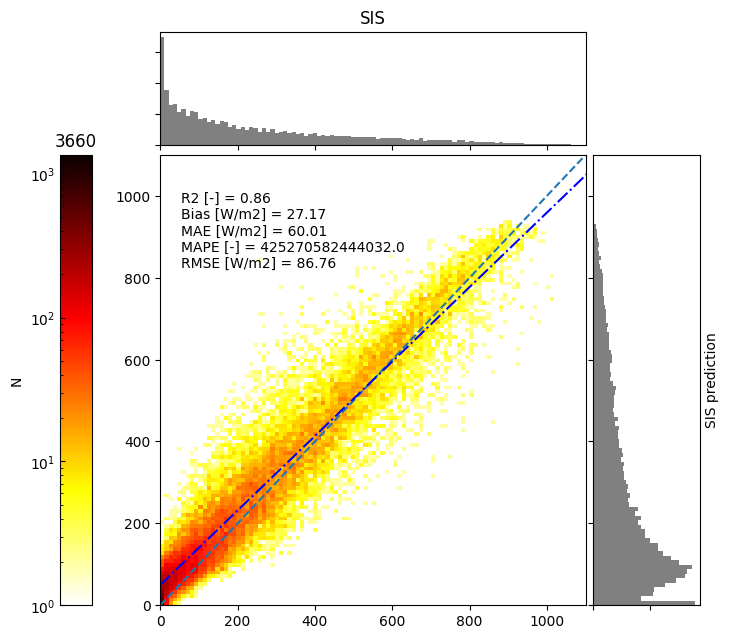

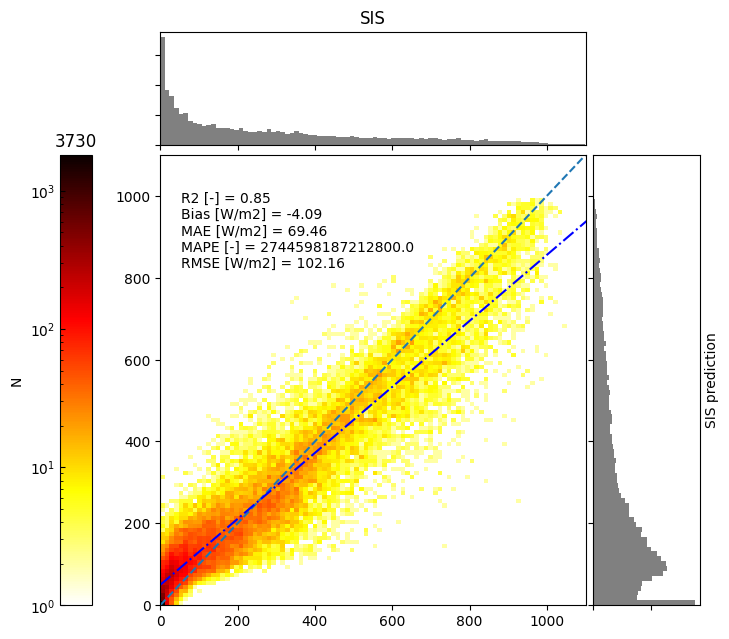

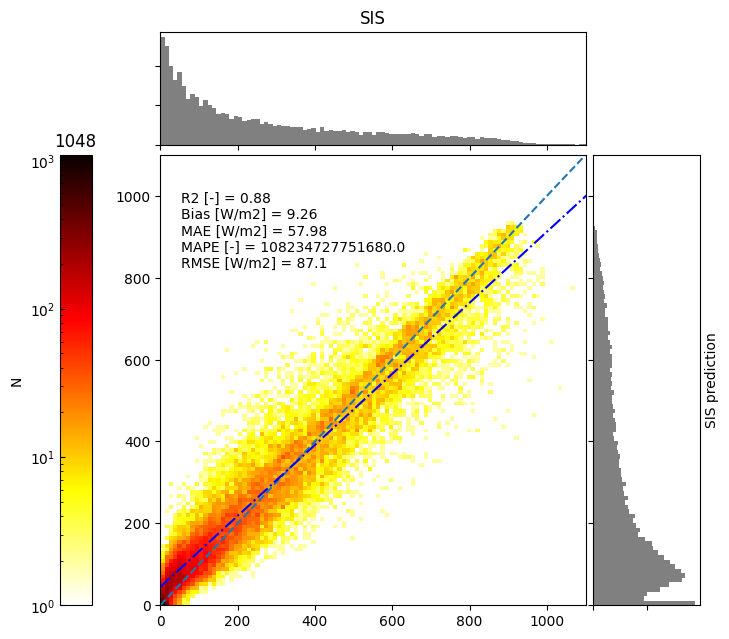

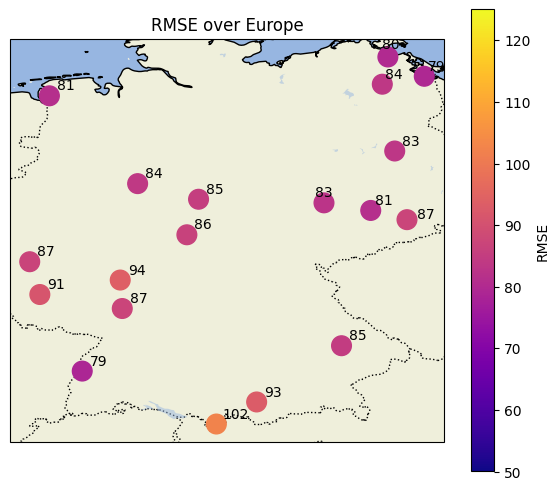

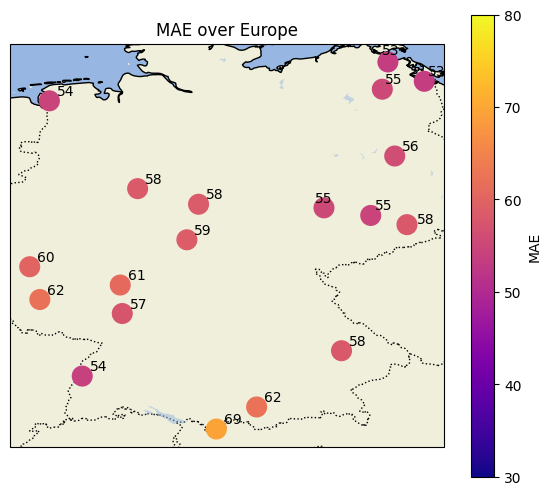

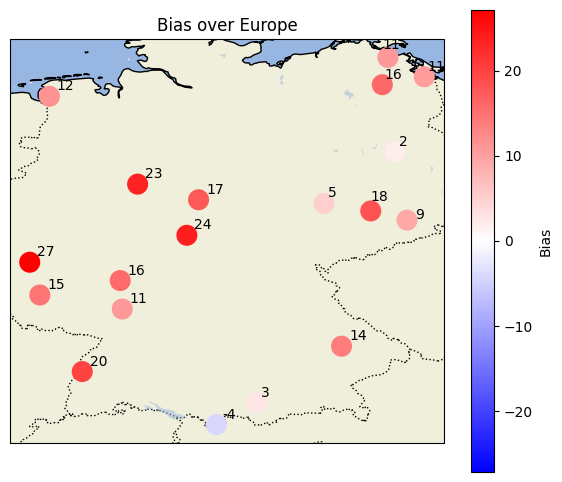

In [12]:
statistics_stations(predictions_validation, True, stations_collection='DWD_valid')

In [13]:
train_datasets = [GroundstationDataset2(f'../../ZARR/DWD/DWD_SOLAR_{str(x).zfill(5)}.zarr', 
                                        config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], 
                                        config.transform, config.target_transform, sarah_idx_only=True)
                            for x in tqdm(train_id)]

100%|██████████| 80/80 [18:26<00:00, 13.83s/it]


In [ ]:
predictions_stations = [trainer.predict(estimator, DataLoader(ds, 2000, shuffle=False)) for ds in train_datasets]

predictions_train = { nm: {'y_hat': torch.cat([p[0] for p in pred]),
                              'y': torch.cat([p[1] for p in pred]),
                              'x': torch.cat([p[2] for p in pred]) } for nm, pred in zip(train_id, predictions_stations)}

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
statistics_stations(predictions_train, True, stations_collection='DWD_train')

## KNMI

In [ ]:
zarr_fns = glob('../../ZARR/KNMI/KNMI_SOLAR_*.zarr')
station_names = [os.path.basename(fn).split('KNMI_SOLAR_')[-1].split('.')[0] for fn in zarr_fns]
index = xarray.open_dataset('/scratch/snx3000/kschuurm/DATA/KNMI/nc/index.nc')
index = index.sel(station=station_names)



# index_train = index.sel(station_id=train_id); index_valid = index.sel(station_id=valid_id)

a = index.plot.scatter(x='lon', y='lat', c='b', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
# index_valid.plot.scatter(x='lon', y='lat', c='r', subplot_kws=dict(projection=ccrs.PlateCarree()), transform=ccrs.PlateCarree())
a.axes.set_extent([-5, 25, 40, 60])
ax = a.axes
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
plt.gcf().legend(['train', 'validation'])
plt.show()

In [ ]:
datasets = [GroundstationDataset2(f'../../ZARR/KNMI/KNMI_SOLAR_{str(x)}.zarr', 
                                        config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], 
                                        config.transform, config.target_transform, sarah_idx_only=True)
                            for x in tqdm(station_names)]

In [ ]:
predictions = [trainer.predict(estimator, DataLoader(ds, 2000, shuffle=False)) for ds in datasets]

predictions_knmi = { nm: {'y_hat': torch.cat([p[0] for p in pred]),
                              'y': torch.cat([p[1] for p in pred]),
                              'x': torch.cat([p[2] for p in pred]) } for nm, pred in zip(station_names, predictions)}

In [ ]:
statistics_stations(predictions_knmi, True, stations_collection='KNMI')

# Full image comparison

In [ ]:
imageDataset = ImageDataset(
    x_vars=config.x_vars,
    y_vars=config.y_vars,
    x_features=config.x_features,
    patch_size=config.patch_size,
    transform=config.transform,
    target_transform=config.target_transform,
    random_sample=None,
    batch_in_time=None,
    dtype=torch.float32,
)

dts = imageDataset.images

In [ ]:
a = pd.DatetimeIndex([dt[0] for dt in dts])
a = a[a.year == 2016]

In [ ]:
from dataset.dataset import valid_test_split, pickle_write, pickle_read

_, subset = valid_test_split(a)
# subsubset = np.random.choice(subset, 10, replace=False)
subsubset = subset[::40]

In [ ]:
from dataset.dataset import valid_test_split, pickle_write, pickle_read
for dt in tqdm(subsubset[:]):
    try:
        dataset = imageDataset.load_singleImageDataset_generator(dt=[dt]).result()
        

        time_str = dataset.sarah.time.dt.strftime('%Y%m%d_%H%M').item()
        fn = inference_fn + f'predictions/predictions_{time_str}.pkl'
        os.makedirs(os.path.dirname(fn), exist_ok=True)
        if not os.path.exists(fn):
            dataloader = DataLoader(dataset, batch_size=1000, num_workers=3)
            predictions = trainer.predict(estimator, dataloader)
            pickle_write(predictions, fn)
        else:
            predictions = pickle_read(fn)

        output_image, y, y_hat = predictions_to_image(
            predictions, dataset.sarah, config, config.patch_size
        )
        plot_comparison_image(output_image, dataset.sarah.isel(time=0).SIS)#, extent=[5, 40, 15,50])

        fig = prediction_error_plot(y.flatten(), y_hat.flatten())
        time_str = dataset.sarah.time.dt.strftime('%Y%m%d_%H%M').item()
        fig.savefig(inference_fn + f'prediction_error_plot_{time_str}.png')
    except Exception as e:
        print(dt)
        print(e)
        

In [ ]:
dataset = imageDataset.load_singleImageDataset_generator(dt=dts[4200]).result()

In [ ]:
dataloader = DataLoader(dataset, batch_size=1000, num_workers=3)
predictions = trainer.predict(estimator, dataloader)

In [ ]:
output_image, y, y_hat = predictions_to_image(
    predictions, dataset.sarah, config, config.patch_size
)

In [ ]:
plot_comparison_image(output_image, dataset.sarah.isel(time=0).SIS)#, extent=[5, 40, 15,50])

fig = prediction_error_plot(y.flatten(), y_hat.flatten())
time_str = dataset.sarah.time.dt.strftime('%Y%m%d_%H%M').item()
fig.savefig(inference_fn + f'prediction_error_plot_{time_str}.png')